## Clear python3

In [1]:
%reset -f

## Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials
plt.style.use("ggplot")

## Load Data from Yahoo Financials

In [3]:
ticker = yf.Ticker('^GSPC')
df = ticker.history(period='max', auto_adjust = True)
df['pct_change'] = df["Close"].pct_change()
df['log_ret'] = np.log(df["Close"]) - np.log(df["Close"].shift(1))

## Remove na and zeros

In [4]:
df.dropna(inplace=True)
df = df[df.log_ret!=0]
df.shape

(22996, 9)

## Select period

In [5]:
df = df.loc["01-01-1950":]

## Online QML GARCH(p,q) Estimation

In [6]:
# https://gist.github.com/daien/1272551/edd95a6154106f8e28209a1c7964623ef8397246
def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / rho
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

In [7]:
# https://gist.github.com/daien/1272551/edd95a6154106f8e28209a1c7964623ef8397246
def euclidean_proj_l1ball(v, s=1):
    """ Compute the Euclidean projection on a L1-ball
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the L1-ball
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s
    Notes
    -----
    Solves the problem by a reduction to the positive simplex case
    See also
    --------
    euclidean_proj_simplex
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # compute the vector of absolute values
    u = np.abs(v)
    # check if v is already a solution
    if u.sum() <= s:
        # L1-norm is <= s
        return v
    # v is not already a solution: optimum lies on the boundary (norm == s)
    # project *u* on the simplex
    w = euclidean_proj_simplex(u, s=s)
    # compute the solution to the original problem on v
    w *= np.sign(v)
    return w

In [8]:
def proj_l1ball(v, s=1, eps=10**(-8)):
    """
    Project positive parameters onto the L1-ball
    """
    v = euclidean_proj_l1ball(np.maximum(v, eps), s=s)
    return v

In [9]:
def adavol(x, theta_initial, p=1, q=1, eta=0.1, eps=10**(-8)):
    """
    Estimate theta_hat for every observation
    """
    
    # Check for initial values
    assert len(theta_initial) == p+q, "Missing initial guess for all p+q parameters!"
    assert np.sum(theta_initial) <= 1.0, "Sum of initial value must be less than one!"
    assert p >= 1, "Parameter p must be at least one!"
    assert q >= 0, "Parameter q must be at least zero!"

    # Number of observations
    n = len(x)
    
    # Make matrix for estimates
    theta_hat = np.zeros((p+q, n))
    theta_hat[:,0] = theta_initial
    
    # Initialize 
    sigma2_hat = np.zeros(q+2)  # [sigma2_hat[t+1], sigma2_hat[t], sigma2_hat[t-1], ...,sigma2_hat[t-q]]^T
    sigma2_hat[0] = x[0]**2  # sigma2_hat
    mu_hat = np.ones(1)*x[0]  # sample mean
    gamma2_hat = np.zeros(1)  # sample variance
    vartheta_hat = np.zeros(p+q)  # vartheta hat used for gradient
    nabla_sigma2_hat = np.zeros((p+q, q+1)) # nabla sigma2 hat used for gradient
    g_hat = np.zeros(p+q)  # gradient
    G_hat = np.zeros(p+q)+eps  # accumulated squared gradients
    t = 0  # time
    
    # Start recursive
    while t < n-1:
        
        # update time
        t = t+1

        # shift sigma2_hat and nabla_sigma2_hat
        sigma2_hat = np.concatenate((np.zeros(1), sigma2_hat[:-1]))
        nabla_sigma2_hat = np.hstack((np.zeros((p+q, 1)), nabla_sigma2_hat[:, :-1]))
        
        # update sample mean
        mu_hat = t/(t+1)*mu_hat + 1/(t+1)*x[t]
        
        # update sample variance
        gamma2_hat = (t-1)/t*gamma2_hat + 1/t*(x[t]-mu_hat)**2
        
        # compute gradient
        vartheta_hat = np.concatenate((x[max(t-p,0):t][::-1]**2, np.zeros(abs(min(t-p,0))), sigma2_hat[2:])) 
        nabla_sigma2_hat[:,0] = (vartheta_hat - gamma2_hat) + theta_hat[p:,t-1].reshape(1,q).dot(nabla_sigma2_hat[:, 1:].T)
        g_hat = nabla_sigma2_hat[:,0] * ((sigma2_hat[1] - x[t]**2)/(2*(sigma2_hat[1]**2)))

        # update accumulated squared gradients
        G_hat = G_hat + g_hat**2
        
        # Update estimates (projected)
        theta_hat[:,t] = proj_l1ball(theta_hat[:, t-1] - eta/np.sqrt(G_hat) * g_hat, s=1, eps=eps)
            
        # predict sigma2_hat
        alpha_term = np.sum([theta_hat[i,t-1] * x[t-i]**2 for i in np.arange(0, p)])
        beta_term = np.sum([theta_hat[p+j,t-1] * sigma2_hat[j+1] for j in np.arange(0, q)])
        sigma2_hat[0] = gamma2_hat*(1 - np.sum(theta_hat[:, t-1])) + alpha_term + beta_term

    return theta_hat

In [10]:
p, q = 1, 1
theta_initial = np.concatenate([np.ones(p)*0.05, np.ones(q)*0.90])
theta_hat = adavol(df.log_ret.values, theta_initial, p=p, q=q)

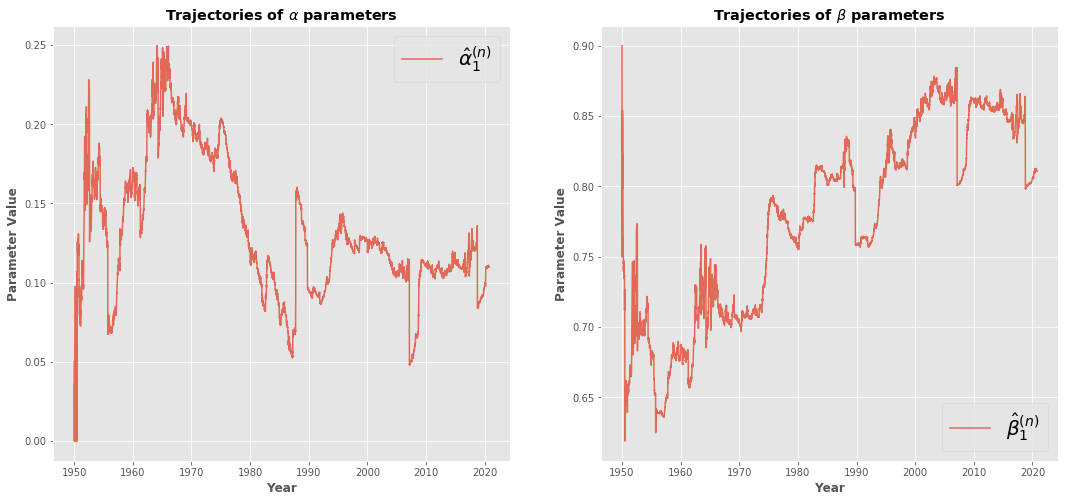

In [11]:
# Plot of Theta
plots = 2
plt.figure(figsize=(18, 8))

# Alpha
plt.subplot(1, 2, 1)
plt.title(r"Trajectories of $\alpha$ parameters", fontweight='bold')
for i in np.arange(0, p):
    plt.plot(pd.DataFrame(theta_hat[i], index=df.index), label=r'$\hat{\alpha}^{(n)}_{'+str(1+i)+'}$', alpha = 0.8)
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Parameter Value", fontweight='bold')
plt.legend(prop={'size': 20})

# Beta
plt.subplot(1, 2, 2)
plt.title(r"Trajectories of $\beta$ parameters", fontweight='bold')
for j in np.arange(p, p+q):
    plt.plot(pd.DataFrame(theta_hat[j], index=df.index), label=r'$\hat{\beta}^{(n)}_{'+str(1+j-p)+'}$', alpha = 0.8)
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Parameter Value", fontweight='bold')
plt.legend(prop={'size': 20})

plt.show()